In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_13(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_13, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.layer2(x))
    

        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)

        x = torch.relu(self.layer4(x))
        
        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_13(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [12]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:17:58,614] A new study created in memory with name: no-name-5d4a173e-8e54-4d2d-a111-ca31617016a4
/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:19:58,977] Trial 0 finished with value: 0.29072133077420836 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00029622327777218776, 'weight_decay': 0.003222782445189349

Early stopping at epoch 35
Final MCC: 0.2907


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:21:00,556] Trial 1 finished with value: 0.3745664757860791 and parameters: {'dropout1': 0.05, 'dropout2': 0.30000000000000004, 'learning_rate': 0.002331968734190863, 'weight_decay': 0.00028045560110205847}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 17
Final MCC: 0.3746


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:23:20,283] Trial 2 finished with value: 0.2065672005770008 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00015900158331202987, 'weight_decay': 0.0001630353842761346}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 41
Final MCC: 0.2066


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:25:06,834] Trial 3 finished with value: 0.17240592127803883 and parameters: {'dropout1': 0.2, 'dropout2': 0.0, 'learning_rate': 0.0002246603347437356, 'weight_decay': 6.67299991051314e-05}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 31
Final MCC: 0.1724


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:26:58,887] Trial 4 finished with value: 0.3007160357898652 and parameters: {'dropout1': 0.0, 'dropout2': 0.2, 'learning_rate': 0.00017475574153164608, 'weight_decay': 0.0037460131375954735}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 32
Final MCC: 0.3007


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:28:19,892] Trial 5 finished with value: 0.3240593575912021 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.008338386782481761, 'weight_decay': 0.00172263730343949}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 23
Final MCC: 0.3241


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:29:28,828] Trial 6 finished with value: 0.30687471763976343 and parameters: {'dropout1': 0.2, 'dropout2': 0.0, 'learning_rate': 0.0016982954835003373, 'weight_decay': 0.000440082265974846}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 19
Final MCC: 0.3069


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:29:32,312] Trial 7 pruned. 
[I 2024-12-04 16:29:35,786] Trial 8 pruned. 
[I 2024-12-04 16:29:39,277] Trial 9 pruned. 
[I 2024-12-04 16:29:42,821] Trial 10 pruned. 
[I 2024-12-04 16:30:39,258] Trial 11 finished with value: 0.3333528459316899 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'learning_

Early stopping at epoch 15
Final MCC: 0.3334


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:30:42,600] Trial 12 pruned. 
[I 2024-12-04 16:30:45,882] Trial 13 pruned. 
[I 2024-12-04 16:30:49,160] Trial 14 pruned. 
[I 2024-12-04 16:30:52,393] Trial 15 pruned. 
[I 2024-12-04 16:30:55,666] Trial 16 pruned. 
[I 2024-12-04 16:30:59,257] Trial 17 pruned. 
[I 2024-12-04 16:31:02,772] Trial 18 pruned. 
[I 2024-12-04 16:31:06,363] T

Early stopping at epoch 14
Final MCC: 0.3144


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:32:27,042] Trial 28 pruned. 
[I 2024-12-04 16:34:17,452] Trial 29 finished with value: 0.3151705454644322 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00010392990332231655, 'weight_decay': 0.002862993205386381}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 30
Final MCC: 0.3152


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:34:21,060] Trial 30 pruned. 
[I 2024-12-04 16:37:45,656] Trial 31 finished with value: 0.2956695465288894 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00010496815535459859, 'weight_decay': 0.0035330397638758896}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 55
Final MCC: 0.2957


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:15,042] Trial 32 finished with value: 0.3058656435219968 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.00010290142887811763, 'weight_decay': 0.002346262979126739}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 40
Final MCC: 0.3059


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:18,773] Trial 33 pruned. 
[I 2024-12-04 16:40:22,445] Trial 34 pruned. 
[I 2024-12-04 16:40:26,085] Trial 35 pruned. 
[I 2024-12-04 16:40:29,884] Trial 36 pruned. 
[I 2024-12-04 16:40:33,796] Trial 37 pruned. 
[I 2024-12-04 16:40:37,612] Trial 38 pruned. 
[I 2024-12-04 16:40:41,420] Trial 39 pruned. 
[I 2024-12-04 16:40:45,193] T

Early stopping at epoch 18
Final MCC: 0.0000


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:44:19,457] Trial 48 finished with value: 0.3122509631408799 and parameters: {'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0061343612371931805, 'weight_decay': 0.0007718763803592798}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 33
Final MCC: 0.3123


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:44:23,209] Trial 49 pruned. 
[I 2024-12-04 16:44:27,038] Trial 50 pruned. 
[I 2024-12-04 16:45:42,863] Trial 51 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'learning_rate': 0.006168651726303626, 'weight_decay': 0.0007365373307312108}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 20
Final MCC: 0.0000


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:45:46,493] Trial 52 pruned. 
[I 2024-12-04 16:47:03,298] Trial 53 finished with value: 0.0 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'learning_rate': 0.004716148486661507, 'weight_decay': 0.0004971005493706}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 20
Final MCC: 0.0000


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:47:06,888] Trial 54 pruned. 
[I 2024-12-04 16:47:10,535] Trial 55 pruned. 
[I 2024-12-04 16:47:14,115] Trial 56 pruned. 
[I 2024-12-04 16:47:17,717] Trial 57 pruned. 
[I 2024-12-04 16:47:21,340] Trial 58 pruned. 
[I 2024-12-04 16:47:24,922] Trial 59 pruned. 
[I 2024-12-04 16:47:28,536] Trial 60 pruned. 
[I 2024-12-04 16:47:32,121] T

Early stopping at epoch 38
Final MCC: 0.3046


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:50:35,722] Trial 73 pruned. 
[I 2024-12-04 16:53:58,275] Trial 74 finished with value: 0.29953928510069794 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.00013734881325767095, 'weight_decay': 0.0027935052648980665}. Best is trial 1 with value: 0.3745664757860791.


Early stopping at epoch 53
Final MCC: 0.2995


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:54:02,111] Trial 75 pruned. 
[I 2024-12-04 16:54:05,894] Trial 76 pruned. 
[I 2024-12-04 16:54:09,704] Trial 77 pruned. 
[I 2024-12-04 16:54:13,437] Trial 78 pruned. 
[I 2024-12-04 16:54:17,155] Trial 79 pruned. 
[I 2024-12-04 16:54:20,833] Trial 80 pruned. 
[I 2024-12-04 16:59:08,114] Trial 81 finished with value: 0.294609606950319

Early stopping at epoch 76
Final MCC: 0.2946


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:59:12,023] Trial 82 pruned. 
[I 2024-12-04 16:59:15,832] Trial 83 pruned. 
[I 2024-12-04 16:59:19,684] Trial 84 pruned. 
[I 2024-12-04 16:59:23,514] Trial 85 pruned. 
[I 2024-12-04 16:59:27,160] Trial 86 pruned. 
[I 2024-12-04 17:01:26,239] Trial 87 finished with value: 0.268529507339366 and parameters: {'dropout1': 0.25, 'dropout2'

Early stopping at epoch 31
Final MCC: 0.2685


/tmp/ipykernel_283289/2122863123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283289/2122863123.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:01:30,061] Trial 88 pruned. 
[I 2024-12-04 17:01:33,920] Trial 89 pruned. 
[I 2024-12-04 17:01:37,792] Trial 90 pruned. 
[I 2024-12-04 17:01:41,629] Trial 91 pruned. 
[I 2024-12-04 17:01:45,454] Trial 92 pruned. 
[I 2024-12-04 17:01:49,306] Trial 93 pruned. 
[I 2024-12-04 17:01:53,151] Trial 94 pruned. 
[I 2024-12-04 17:01:56,997] T

Best Parameters:  {'dropout1': 0.05, 'dropout2': 0.30000000000000004, 'learning_rate': 0.002331968734190863, 'weight_decay': 0.00028045560110205847}
Best Validation F1:  0.3745664757860791


Epoch [1/100], Loss: 0.5883
Epoch [1/100], Train Loss: 0.5883, Val Loss: 0.5894
Epoch [2/100], Loss: 0.5709
Epoch [2/100], Train Loss: 0.5709, Val Loss: 0.5635
Epoch [3/100], Loss: 0.5693
Epoch [3/100], Train Loss: 0.5693, Val Loss: 0.5610
Epoch [4/100], Loss: 0.5698
Epoch [4/100], Train Loss: 0.5698, Val Loss: 0.5722
Epoch [5/100], Loss: 0.5729
Epoch [5/100], Train Loss: 0.5729, Val Loss: 0.5685
Epoch [6/100], Loss: 0.5666
Epoch [6/100], Train Loss: 0.5666, Val Loss: 0.5651
Epoch [7/100], Loss: 0.5629
Epoch [7/100], Train Loss: 0.5629, Val Loss: 0.5663
Epoch [8/100], Loss: 0.5628
Epoch [8/100], Train Loss: 0.5628, Val Loss: 0.5644
Epoch [9/100], Loss: 0.5644
Epoch [9/100], Train Loss: 0.5644, Val Loss: 0.5632
Epoch [10/100], Loss: 0.5598
Epoch [10/100], Train Loss: 0.5598, Val Loss: 0.5740
Epoch [11/100], Loss: 0.5615
Epoch [11/100], Train Loss: 0.5615, Val Loss: 0.5670
Epoch [12/100], Loss: 0.5615
Epoch [12/100], Train Loss: 0.5615, Val Loss: 0.5630
Epoch [13/100], Loss: 0.5600
Epoch

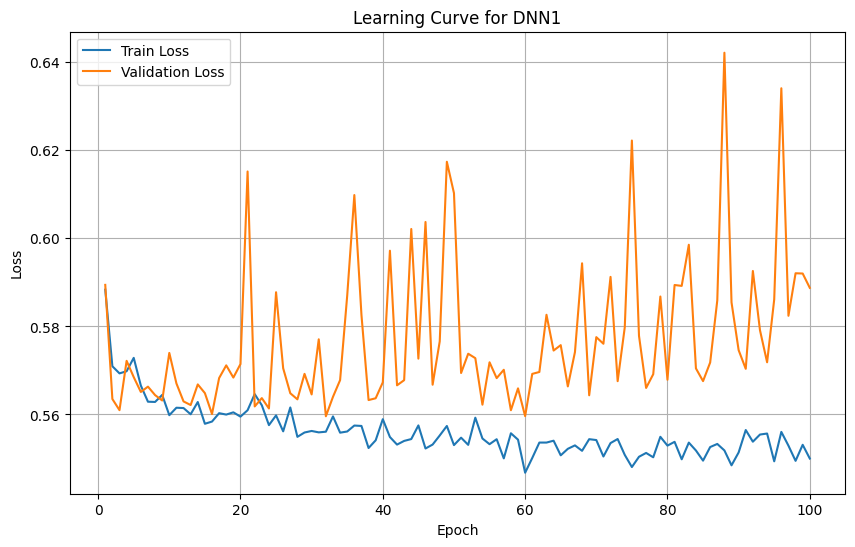

In [13]:
best_params=study.best_params
model = DNN_13(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 57.52%
Precision: 0.4749
Recall: 0.9499
F1 Score: 0.6332
Matthews Correlation Coefficient: 0.3359
Specificity: 0.3395


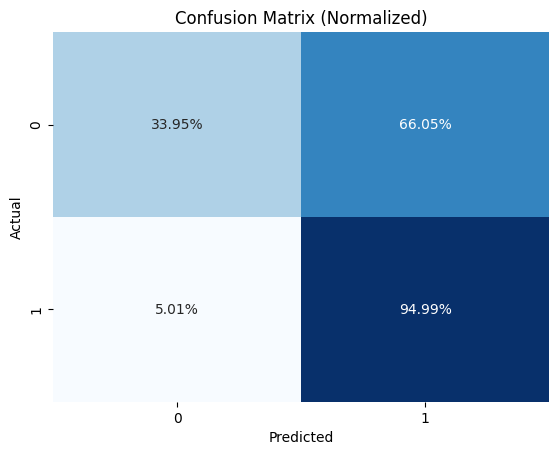

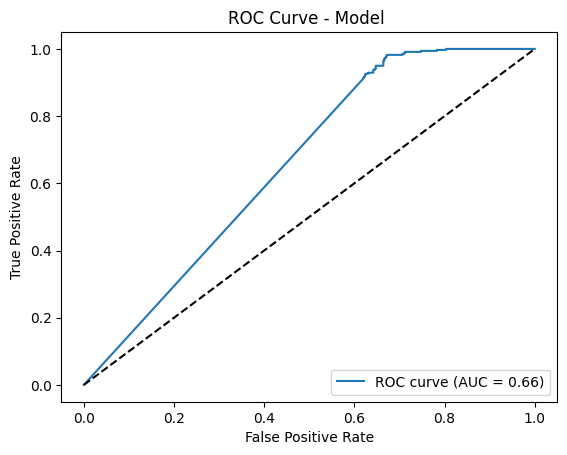

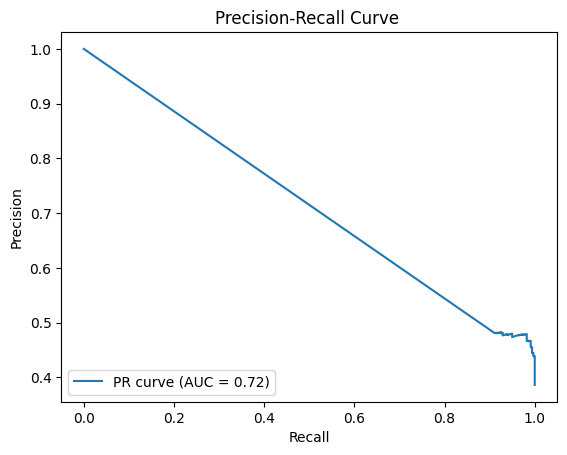

In [14]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_13.pth')

